In [1]:
import os
import glob
import re
import datetime
import glob
from datetime import date, time, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
from cv2 import VideoCapture, CAP_PROP_FRAME_COUNT, CAP_PROP_FPS, CAP_PROP_POS_FRAMES
import ffmpeg
from imutils.video import FileVideoStream
import time
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Span, DatetimeTicker, DatetimeTickFormatter
from scipy import stats
from utils import load_diffs, load_slide_changes, load_intervals
from utils import filter_video, plot_slide_diffs, get_signals, evaluate
from utils import sanitize_signals

sns.set()
output_notebook()

Loading BokehJS ...

# Paths

In [2]:
meeting_id = 160320
#meeting_id = 220120
#meeting_id = 170127
#meeting_id = 83512718053

In [3]:
masked = True

In [4]:
video_path = glob.glob(f'zoom_data/{meeting_id}/*.mp4')[0]
print(video_path)
if masked:
    diff_path = f'diff_data/diffs_{meeting_id}_masked_cossim.csv'
else:
    diff_path = f'diff_data/diffs_{meeting_id}_cossim.csv'
sc_labels = f'slide_change_labels/{meeting_id}.csv'
interval_path = 'interval_data/intervals.csv'

zoom_data/160320/GMT20210614-160320_Recording_2020x1380.mp4


# Load FPS, Diffs, and Slide Change Labels

In [5]:
vidcap = VideoCapture(video_path)
fps = vidcap.get(CAP_PROP_FPS)
ddiffs = load_diffs(diff_path, fps)
sldf = load_slide_changes(sc_labels)
idf = load_intervals(interval_path, meeting_id=meeting_id)

# Visualize

In [6]:
q = 0.75
ddiffs = filter_video(ddiffs, sldf, idf)
signals, threshold_q = get_signals(ddiffs, threshold_q=q)
print(f"Threshold is set at {threshold_q} percentile")

Threshold is set at 0.75 percentile


In [7]:
plot_slide_diffs(ddiffs, sldf=sldf, signals=signals)

# Evaluate

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

In [8]:
_, prec, recall = evaluate(ddiffs, sldf)
print(f'Precision: {prec:.2}\nRecall: {recall:.2}')

Precision: 1.0
Recall: 0.89


In [7]:
_, mean_q = get_signals(ddiffs)
percentiles = np.arange(mean_q / 100 - 0.1, 1.0, 0.001)
scores = []
for q in percentiles:
    _, prec, recall = evaluate(ddiffs, sldf, threshold_q=q)
    scores.extend([{'q': q, 'score': 'recall', 'value': recall},
                   {'q': q, 'score': 'precision', 'value': prec}])
sdf = pd.DataFrame(scores)

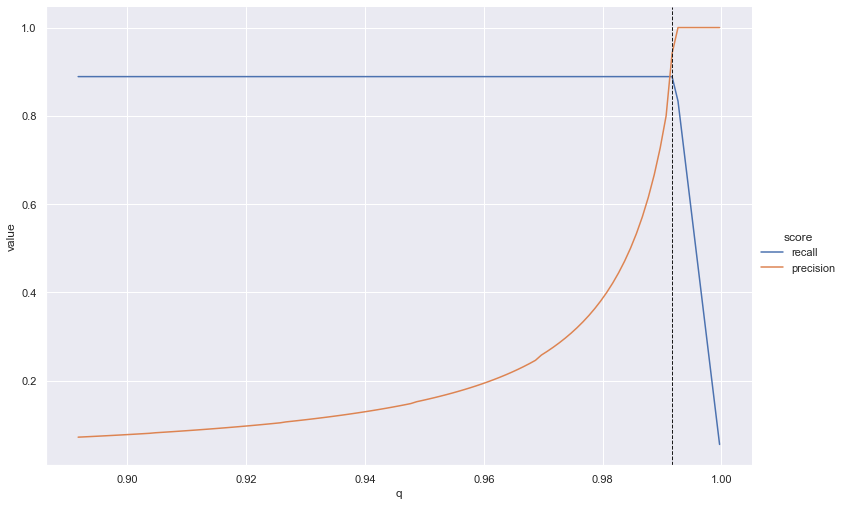

In [8]:
sns.relplot(x='q', y='value', hue='score', data=sdf,
            kind='line', height=7, aspect=1.5);
plt.axvline(mean_q / 100, c='k', linestyle='dashed', linewidth=1);

## Debug eval

In [11]:
threshold_q = percentiles[0]

In [27]:
results, _, _ = evaluate(ddiffs, sldf)
#results, _, _ = evaluate(ddiffs, sldf, threshold_q=threshold_q)

In [28]:
p = figure(plot_width=1400, plot_height=500, x_axis_type='datetime')
p.line(results.elapsed_dt, 
       results.change_time_dt.notna().cumsum(), 
       line_width=2, 
       line_alpha=0.5,
       color='blue',
       legend_label='slide_changes')
p.line(results.elapsed_dt, 
       ((results.signal.astype(int) + results.plus.notna() + results.minus.notna()) > 1).cumsum(), 
       line_width=2, 
       line_alpha=0.5,
       color='red',
       legend_label='correct_signals')

p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%H:%M:%S', minsec='%H:%M:%S', hourmin='%H:%M:%S', seconds='%H:%M:%S', hours='%H')
p.xaxis.major_label_orientation = "vertical"
show(p)

In [29]:
signals, _ = get_signals(ddiffs)
#signals, _ = get_signals(ddiffs, threshold_q=threshold_q)

In [30]:
plot_slide_diffs(ddiffs, sldf=sldf, signals=signals)

In [31]:
results

,elapsed_dt,change_time_dt,cos_sim_diff,signal,plus,minus,signal_to_change_time_dt,max_diff,keep_signal
0,1970-01-01 00:01:22,1970-01-01 00:01:22,0.000000e+00,False,NaT,NaT,1970-01-01 00:01:22,0.00000,True
1,1970-01-01 00:01:23,NaT,0.000000e+00,False,1970-01-01 00:01:22,NaT,1970-01-01 00:01:22,0.00000,True
2,1970-01-01 00:01:24,NaT,0.000000e+00,False,NaT,NaT,NaT,NaN,False
3,1970-01-01 00:01:25,NaT,0.000000e+00,False,NaT,NaT,NaT,NaN,False
4,1970-01-01 00:01:26,NaT,0.000000e+00,False,NaT,NaT,NaT,NaN,False
...,...,...,...,...,...,...,...,...,...
1961,1970-01-01 00:34:03,NaT,7.380545e-07,False,NaT,NaT,NaT,NaN,False
1962,1970-01-01 00:34:04,NaT,3.186563e-05,False,NaT,NaT,NaT,NaN,False
1963,1970-01-01 00:34:05,NaT,4.945095e-09,False,NaT,NaT,NaT,NaN,False
1964,1970-01-01 00:34:06,NaT,2.570800e-01,True,NaT,1970-01-01 00:34:07,1970-01-01 00:34:07,0.25708,True


In [32]:
results.change_time_dt.notna().sum()

18

In [33]:
results.signal.sum()

15

In [35]:
(results.signal & results.keep_signal).sum()

15

In [36]:
correct_signals = results.loc[results.signal & results.keep_signal, ['change_time_dt', 'plus', 'minus']]
correct_signals

,change_time_dt,plus,minus
33,NaT,NaT,1970-01-01 00:01:56
38,NaT,NaT,1970-01-01 00:02:01
132,1970-01-01 00:03:34,NaT,NaT
316,NaT,NaT,1970-01-01 00:06:39
361,NaT,NaT,1970-01-01 00:07:24
460,1970-01-01 00:09:02,NaT,NaT
528,NaT,NaT,1970-01-01 00:10:11
684,NaT,NaT,1970-01-01 00:12:47
835,1970-01-01 00:15:17,NaT,NaT
990,1970-01-01 00:17:52,NaT,NaT


In [38]:
correct_signals.notna().sum(axis=1)

33      1
38      1
132     1
316     1
361     1
460     1
528     1
684     1
835     1
990     1
1170    1
1454    1
1821    2
1863    1
1964    1
dtype: int64

## Refactor eval

#### Get input dfs

In [7]:
ddiffs.head()

,meeting_id,elapsed_dt,cos_sim_diff
0,160320,1970-01-01 00:00:00,NaN
1,160320,1970-01-01 00:00:01,0.000000
2,160320,1970-01-01 00:00:02,0.000038
3,160320,1970-01-01 00:00:03,0.000000
4,160320,1970-01-01 00:00:04,0.000000


In [8]:
sldf.head()

,change_time,note,change_time_dt
0,0:1:22,NaN,1970-01-01 00:01:22
1,0:1:56,NaN,1970-01-01 00:01:56
2,0:2:01,NaN,1970-01-01 00:02:01
3,0:3:34,Revisited 2 slides back,1970-01-01 00:03:34
4,0:6:39,Fast forward 2 slides to next slide,1970-01-01 00:06:39


In [9]:
signals.head()

,elapsed_dt,signal
0,1970-01-01 00:00:00,False
1,1970-01-01 00:00:01,False
2,1970-01-01 00:00:02,True
3,1970-01-01 00:00:03,False
4,1970-01-01 00:00:04,False


#### Join into initial results

In [10]:
results = ddiffs[['elapsed_dt', 'cos_sim_diff']] \
            .merge(sldf[['change_time_dt']],
                   how='left',
                   left_on='elapsed_dt',
                   right_on='change_time_dt') \
            .merge(signals, how='left', on='elapsed_dt')
results

,elapsed_dt,cos_sim_diff,change_time_dt,signal
0,1970-01-01 00:00:00,NaN,NaT,False
1,1970-01-01 00:00:01,0.000000e+00,NaT,False
2,1970-01-01 00:00:02,3.792219e-05,NaT,True
3,1970-01-01 00:00:03,0.000000e+00,NaT,False
4,1970-01-01 00:00:04,0.000000e+00,NaT,False
...,...,...,...,...
2043,1970-01-01 00:34:03,7.380545e-07,NaT,True
2044,1970-01-01 00:34:04,3.186563e-05,NaT,True
2045,1970-01-01 00:34:05,4.945095e-09,NaT,False
2046,1970-01-01 00:34:06,2.570800e-01,NaT,True


#### Map signals to slide changes within +/- 1 sec

In [11]:
results['plus'] = results.change_time_dt.shift()
results['minus'] = results.change_time_dt.shift(-1)
results['signal_to_change_time_dt'] = np.where(results.change_time_dt.notna(),
                                               results.change_time_dt,
                                               results[['plus', 'minus']].max(axis=1))
results

,elapsed_dt,cos_sim_diff,change_time_dt,signal,plus,minus,signal_to_change_time_dt
0,1970-01-01 00:00:00,NaN,NaT,False,NaT,NaT,NaT
1,1970-01-01 00:00:01,0.000000e+00,NaT,False,NaT,NaT,NaT
2,1970-01-01 00:00:02,3.792219e-05,NaT,True,NaT,NaT,NaT
3,1970-01-01 00:00:03,0.000000e+00,NaT,False,NaT,NaT,NaT
4,1970-01-01 00:00:04,0.000000e+00,NaT,False,NaT,NaT,NaT
...,...,...,...,...,...,...,...
2043,1970-01-01 00:34:03,7.380545e-07,NaT,True,NaT,NaT,NaT
2044,1970-01-01 00:34:04,3.186563e-05,NaT,True,NaT,NaT,NaT
2045,1970-01-01 00:34:05,4.945095e-09,NaT,False,NaT,NaT,NaT
2046,1970-01-01 00:34:06,2.570800e-01,NaT,True,NaT,1970-01-01 00:34:07,1970-01-01 00:34:07


#### Get max diffs in the event there are multiple signals for a given slide change

In [12]:
maxes = results.groupby(['signal', 'signal_to_change_time_dt'], dropna=False, as_index=False) \
                .cos_sim_diff \
                .max() \
                .rename(columns={'cos_sim_diff': 'max_diff'}) \
                .dropna(subset=['signal_to_change_time_dt'])
maxes.head()

,signal,signal_to_change_time_dt,max_diff
0,False,1970-01-01 00:01:22,0.0
1,False,1970-01-01 00:01:56,0.0
2,False,1970-01-01 00:02:01,0.0
3,False,1970-01-01 00:03:34,0.0
4,False,1970-01-01 00:06:39,0.0


In [13]:
results = results.merge(maxes, how='left', on=['signal','signal_to_change_time_dt'])
results.max_diff = np.where(results.max_diff.isna(), results.cos_sim_diff, results.max_diff)
results['keep_signal'] = results.max_diff == results.cos_sim_diff
results.head()

,elapsed_dt,cos_sim_diff,change_time_dt,signal,plus,minus,signal_to_change_time_dt,max_diff,keep_signal
0,1970-01-01 00:00:00,NaN,NaT,False,NaT,NaT,NaT,NaN,False
1,1970-01-01 00:00:01,0.000000,NaT,False,NaT,NaT,NaT,0.000000,True
2,1970-01-01 00:00:02,0.000038,NaT,True,NaT,NaT,NaT,0.000038,True
3,1970-01-01 00:00:03,0.000000,NaT,False,NaT,NaT,NaT,0.000000,True
4,1970-01-01 00:00:04,0.000000,NaT,False,NaT,NaT,NaT,0.000000,True


In [15]:
results.shape

(2048, 9)

In [16]:
results.query('keep_signal').shape

(2043, 9)

In [17]:
results2 = sanitize_signals(ddiffs, sldf, signals)

In [18]:
results2.shape

(2043, 4)

In [19]:
results.head()

,elapsed_dt,cos_sim_diff,change_time_dt,signal,plus,minus,signal_to_change_time_dt,max_diff,keep_signal
0,1970-01-01 00:00:00,NaN,NaT,False,NaT,NaT,NaT,NaN,False
1,1970-01-01 00:00:01,0.000000,NaT,False,NaT,NaT,NaT,0.000000,True
2,1970-01-01 00:00:02,0.000038,NaT,True,NaT,NaT,NaT,0.000038,True
3,1970-01-01 00:00:03,0.000000,NaT,False,NaT,NaT,NaT,0.000000,True
4,1970-01-01 00:00:04,0.000000,NaT,False,NaT,NaT,NaT,0.000000,True


In [24]:
(results.cos_sim_diff != results.max_diff).sum()

5

In [27]:
results.loc[results.keep_signal & (results.cos_sim_diff != results.max_diff), :]

,elapsed_dt,cos_sim_diff,change_time_dt,signal,plus,minus,signal_to_change_time_dt,max_diff,keep_signal


In [20]:
results2.head()

,elapsed_dt,change_time_dt,signal,signal_to_change_time_dt
1,1970-01-01 00:00:01,NaT,False,NaT
2,1970-01-01 00:00:02,NaT,True,NaT
3,1970-01-01 00:00:03,NaT,False,NaT
4,1970-01-01 00:00:04,NaT,False,NaT
5,1970-01-01 00:00:05,NaT,True,NaT


### Create labels

In [8]:
sanitized_signals = sanitize_signals(ddiffs, sldf, signals)

In [24]:
sanitized_signals

,elapsed_dt,change_time_dt,signal,signal_to_change_time_dt
1,1970-01-01 00:00:01,NaT,False,NaT
2,1970-01-01 00:00:02,NaT,True,NaT
3,1970-01-01 00:00:03,NaT,False,NaT
4,1970-01-01 00:00:04,NaT,False,NaT
5,1970-01-01 00:00:05,NaT,True,NaT
...,...,...,...,...
2043,1970-01-01 00:34:03,NaT,True,NaT
2044,1970-01-01 00:34:04,NaT,True,NaT
2045,1970-01-01 00:34:05,NaT,False,NaT
2046,1970-01-01 00:34:06,NaT,True,1970-01-01 00:34:07


In [9]:
labels = sanitized_signals[['elapsed_dt', 'change_time_dt']] \
            .merge(sanitized_signals[['signal_to_change_time_dt']],
                   how='left', left_on='elapsed_dt', right_on='signal_to_change_time_dt')
labels

,elapsed_dt,change_time_dt,signal_to_change_time_dt
0,1970-01-01 00:00:01,NaT,NaT
1,1970-01-01 00:00:02,NaT,NaT
2,1970-01-01 00:00:03,NaT,NaT
3,1970-01-01 00:00:04,NaT,NaT
4,1970-01-01 00:00:05,NaT,NaT
...,...,...,...
2065,1970-01-01 00:34:04,NaT,NaT
2066,1970-01-01 00:34:05,NaT,NaT
2067,1970-01-01 00:34:06,NaT,NaT
2068,1970-01-01 00:34:07,1970-01-01 00:34:07,1970-01-01 00:34:07


In [10]:
labels['y'] = labels.change_time_dt.notna().astype(int)
labels['yhat'] = labels.signal_to_change_time_dt.notna().astype(int)

In [11]:
labels

,elapsed_dt,change_time_dt,signal_to_change_time_dt,y,yhat
0,1970-01-01 00:00:01,NaT,NaT,0,0
1,1970-01-01 00:00:02,NaT,NaT,0,0
2,1970-01-01 00:00:03,NaT,NaT,0,0
3,1970-01-01 00:00:04,NaT,NaT,0,0
4,1970-01-01 00:00:05,NaT,NaT,0,0
...,...,...,...,...,...
2065,1970-01-01 00:34:04,NaT,NaT,0,0
2066,1970-01-01 00:34:05,NaT,NaT,0,0
2067,1970-01-01 00:34:06,NaT,NaT,0,0
2068,1970-01-01 00:34:07,1970-01-01 00:34:07,1970-01-01 00:34:07,1,1


### Compare scores

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [13]:
print(accuracy_score(labels.y, labels.yhat))

1.0


In [14]:
print(precision_score(labels.y, labels.yhat))

1.0


In [15]:
print(recall_score(labels.y, labels.yhat))

1.0


In [16]:
print(f1_score(labels.y, labels.yhat))

1.0


### Scores are off

In [17]:
signals

,elapsed_dt,signal
0,1970-01-01 00:00:00,False
1,1970-01-01 00:00:01,False
2,1970-01-01 00:00:02,True
3,1970-01-01 00:00:03,False
4,1970-01-01 00:00:04,False
...,...,...
2043,1970-01-01 00:34:03,True
2044,1970-01-01 00:34:04,True
2045,1970-01-01 00:34:05,False
2046,1970-01-01 00:34:06,True


In [22]:
labels.query('y == 1').shape

(45, 5)

In [23]:
labels.query('yhat == 1').shape

(45, 5)

## Filter double counts

In [24]:
results, _, _ = evaluate(ddiffs, sldf)
#results, _, _ = evaluate(ddiffs, sldf, threshold_q=threshold_q)

In [25]:
results.loc[results.change_time_dt.notna(), :]

,elapsed_dt,change_time_dt,cos_sim_diff,signal,plus,minus,signal_to_change_time_dt,max_diff,keep_signal
0,1970-01-01 00:01:22,1970-01-01 00:01:22,0.000000,False,NaT,NaT,1970-01-01 00:01:22,0.000000,True
34,1970-01-01 00:01:56,1970-01-01 00:01:56,0.000000,False,NaT,NaT,1970-01-01 00:01:56,0.000000,True
39,1970-01-01 00:02:01,1970-01-01 00:02:01,0.000000,False,NaT,NaT,1970-01-01 00:02:01,0.000000,True
132,1970-01-01 00:03:34,1970-01-01 00:03:34,0.029001,True,NaT,NaT,1970-01-01 00:03:34,0.029001,True
317,1970-01-01 00:06:39,1970-01-01 00:06:39,0.000000,False,NaT,NaT,1970-01-01 00:06:39,0.000000,True
362,1970-01-01 00:07:24,1970-01-01 00:07:24,0.000000,False,NaT,1970-01-01 00:07:25,1970-01-01 00:07:24,0.000000,True
363,1970-01-01 00:07:25,1970-01-01 00:07:25,0.000000,False,1970-01-01 00:07:24,NaT,1970-01-01 00:07:25,0.000000,True
460,1970-01-01 00:09:02,1970-01-01 00:09:02,0.009946,True,NaT,NaT,1970-01-01 00:09:02,0.009946,True
529,1970-01-01 00:10:11,1970-01-01 00:10:11,0.000000,False,NaT,NaT,1970-01-01 00:10:11,0.000000,True
685,1970-01-01 00:12:47,1970-01-01 00:12:47,0.000000,False,NaT,NaT,1970-01-01 00:12:47,0.000000,True


In [102]:
#results2 = results.iloc[90:160, :].reset_index(drop=True)
results2 = results.iloc[581:607, :].reset_index(drop=True)
results2['signal_to_change_time_dt'] = np.where(results2.change_time_dt.notna(),
                                                results2.change_time_dt,
                                                results2[['plus', 'minus']].max(axis=1))

In [103]:
results2.head(20)

,elapsed_dt,change_time_dt,cos_sim_diff,signal,plus,minus,signal_to_change_time_dt
0,1970-01-01 00:17:33,NaT,0.000000,False,NaT,1970-01-01 00:17:34,1970-01-01 00:17:34
1,1970-01-01 00:17:34,1970-01-01 00:17:34,0.150911,True,NaT,NaT,1970-01-01 00:17:34
2,1970-01-01 00:17:35,NaT,0.000000,False,1970-01-01 00:17:34,NaT,1970-01-01 00:17:34
3,1970-01-01 00:17:36,NaT,0.000112,False,NaT,NaT,NaT
4,1970-01-01 00:17:37,NaT,0.000000,False,NaT,NaT,NaT
5,1970-01-01 00:17:38,NaT,0.000155,False,NaT,NaT,NaT
6,1970-01-01 00:17:39,NaT,0.000000,False,NaT,NaT,NaT
7,1970-01-01 00:17:40,NaT,0.000000,False,NaT,NaT,NaT
8,1970-01-01 00:17:41,NaT,0.000032,False,NaT,NaT,NaT
9,1970-01-01 00:17:42,NaT,0.000000,False,NaT,NaT,NaT


In [104]:
maxes = results2.groupby(['signal', 'signal_to_change_time_dt'], dropna=False, as_index=False) \
                .cos_sim_diff \
                .max() \
                .rename(columns={'cos_sim_diff': 'max_diff'}) \
                .dropna(subset=['signal_to_change_time_dt'])
maxes

,signal,signal_to_change_time_dt,max_diff
0,False,1970-01-01 00:17:34,0.000000
2,True,1970-01-01 00:17:34,0.150911
3,True,1970-01-01 00:17:59,0.190471


In [105]:
results3 = results2.merge(maxes, how='left', on=['signal','signal_to_change_time_dt'])
results3['keep_signal'] = results3.max_diff == results3.cos_sim_diff
results3.head(20)

,elapsed_dt,change_time_dt,cos_sim_diff,signal,plus,minus,signal_to_change_time_dt,max_diff,keep
0,1970-01-01 00:17:33,NaT,0.000000,False,NaT,1970-01-01 00:17:34,1970-01-01 00:17:34,0.000000,True
1,1970-01-01 00:17:34,1970-01-01 00:17:34,0.150911,True,NaT,NaT,1970-01-01 00:17:34,0.150911,True
2,1970-01-01 00:17:35,NaT,0.000000,False,1970-01-01 00:17:34,NaT,1970-01-01 00:17:34,0.000000,True
3,1970-01-01 00:17:36,NaT,0.000112,False,NaT,NaT,NaT,NaN,False
4,1970-01-01 00:17:37,NaT,0.000000,False,NaT,NaT,NaT,NaN,False
5,1970-01-01 00:17:38,NaT,0.000155,False,NaT,NaT,NaT,NaN,False
6,1970-01-01 00:17:39,NaT,0.000000,False,NaT,NaT,NaT,NaN,False
7,1970-01-01 00:17:40,NaT,0.000000,False,NaT,NaT,NaT,NaN,False
8,1970-01-01 00:17:41,NaT,0.000032,False,NaT,NaT,NaT,NaN,False
9,1970-01-01 00:17:42,NaT,0.000000,False,NaT,NaT,NaT,NaN,False


# Add accuracy

In [24]:
ddiffs

,meeting_id,second,l1,l2,cos_sim,elapsed,elapsed_dt,cos_sim_diff
0,170127,1.0,7494322.0,42707.898848,0.000045,00:00:01,1970-01-01 00:00:01,0.000000
1,170127,2.0,7834183.0,43000.270778,0.000126,00:00:02,1970-01-01 00:00:02,0.000081
2,170127,3.0,5603125.0,37003.920157,0.000031,00:00:03,1970-01-01 00:00:03,0.000000
3,170127,4.0,4266665.0,32302.647740,0.000015,00:00:04,1970-01-01 00:00:04,0.000000
4,170127,5.0,19927710.0,70886.563875,0.000033,00:00:05,1970-01-01 00:00:05,0.000019
...,...,...,...,...,...,...,...,...
6142,170127,7134.0,29899581.0,84898.887820,0.000259,01:58:54,1970-01-01 01:58:54,0.000143
6143,170127,7135.0,10338029.0,50001.678862,0.000270,01:58:55,1970-01-01 01:58:55,0.000011
6144,170127,7136.0,8722710.0,44155.029793,0.000211,01:58:56,1970-01-01 01:58:56,0.000000
6145,170127,7137.0,10707840.0,48635.295620,0.000282,01:58:57,1970-01-01 01:58:57,0.000071


In [25]:
sldf

,change_time,note,change_time_dt
0,0:00:01,Presentation started,1970-01-01 00:00:01
1,0:00:57,NaN,1970-01-01 00:00:57
2,0:1:29,NaN,1970-01-01 00:01:29
3,0:2:07,NaN,1970-01-01 00:02:07
4,0:3:35,NaN,1970-01-01 00:03:35
...,...,...,...
70,1:53:17,NaN,1970-01-01 01:53:17
71,1:54:41,NaN,1970-01-01 01:54:41
72,1:55:28,NaN,1970-01-01 01:55:28
73,1:57:08,NaN,1970-01-01 01:57:08


In [7]:
results, _, _ = evaluate(ddiffs, sldf)

In [27]:
results

,elapsed_dt,change_time_dt,cos_sim_diff,signal,plus,minus,signal_to_change_time_dt,max_diff,keep_signal
0,1970-01-01 00:00:01,1970-01-01 00:00:01,0.000000,False,NaT,NaT,1970-01-01 00:00:01,0.000081,False
1,1970-01-01 00:00:02,NaT,0.000081,False,1970-01-01 00:00:01,NaT,1970-01-01 00:00:01,0.000081,True
2,1970-01-01 00:00:03,NaT,0.000000,False,NaT,NaT,NaT,NaN,False
3,1970-01-01 00:00:04,NaT,0.000000,False,NaT,NaT,NaT,NaN,False
4,1970-01-01 00:00:05,NaT,0.000019,False,NaT,NaT,NaT,NaN,False
...,...,...,...,...,...,...,...,...,...
6142,1970-01-01 01:58:54,NaT,0.000143,False,NaT,NaT,NaT,NaN,False
6143,1970-01-01 01:58:55,NaT,0.000011,False,NaT,NaT,NaT,NaN,False
6144,1970-01-01 01:58:56,NaT,0.000000,False,NaT,NaT,NaT,NaN,False
6145,1970-01-01 01:58:57,NaT,0.000071,False,NaT,1970-01-01 01:58:58,1970-01-01 01:58:58,0.000071,True


In [28]:
mask = results.signal & results.keep_signal

In [29]:
results.loc[mask, ['signal_to_change_time_dt', 'max_diff']]

,signal_to_change_time_dt,max_diff
826,1970-01-01 00:13:48,0.004651
871,1970-01-01 00:14:32,0.013340
5052,1970-01-01 01:32:51,0.001296


In [30]:
labels = results[['elapsed_dt', 'change_time_dt']] \
            .merge(results.loc[mask, ['signal_to_change_time_dt', 'max_diff']],
                   how='left', left_on='elapsed_dt', right_on='signal_to_change_time_dt')
labels

,elapsed_dt,change_time_dt,signal_to_change_time_dt,max_diff
0,1970-01-01 00:00:01,1970-01-01 00:00:01,NaT,NaN
1,1970-01-01 00:00:02,NaT,NaT,NaN
2,1970-01-01 00:00:03,NaT,NaT,NaN
3,1970-01-01 00:00:04,NaT,NaT,NaN
4,1970-01-01 00:00:05,NaT,NaT,NaN
...,...,...,...,...
6142,1970-01-01 01:58:54,NaT,NaT,NaN
6143,1970-01-01 01:58:55,NaT,NaT,NaN
6144,1970-01-01 01:58:56,NaT,NaT,NaN
6145,1970-01-01 01:58:57,NaT,NaT,NaN


In [31]:
labels['y'] = labels.change_time_dt.notna().astype(int)
labels['yhat'] = labels.signal_to_change_time_dt.notna().astype(int)

In [32]:
labels

,elapsed_dt,change_time_dt,signal_to_change_time_dt,max_diff,y,yhat
0,1970-01-01 00:00:01,1970-01-01 00:00:01,NaT,NaN,1,0
1,1970-01-01 00:00:02,NaT,NaT,NaN,0,0
2,1970-01-01 00:00:03,NaT,NaT,NaN,0,0
3,1970-01-01 00:00:04,NaT,NaT,NaN,0,0
4,1970-01-01 00:00:05,NaT,NaT,NaN,0,0
...,...,...,...,...,...,...
6142,1970-01-01 01:58:54,NaT,NaT,NaN,0,0
6143,1970-01-01 01:58:55,NaT,NaT,NaN,0,0
6144,1970-01-01 01:58:56,NaT,NaT,NaN,0,0
6145,1970-01-01 01:58:57,NaT,NaT,NaN,0,0


In [16]:
results

,elapsed_dt,change_time_dt,cos_sim_diff,signal,plus,minus,signal_to_change_time_dt,max_diff,keep_signal
0,1970-01-01 00:00:00,NaT,NaN,False,NaT,NaT,NaT,NaN,False
1,1970-01-01 00:00:01,NaT,0.000000e+00,False,NaT,NaT,NaT,NaN,False
2,1970-01-01 00:00:02,NaT,3.792219e-05,False,NaT,NaT,NaT,NaN,False
3,1970-01-01 00:00:03,NaT,0.000000e+00,False,NaT,NaT,NaT,NaN,False
4,1970-01-01 00:00:04,NaT,0.000000e+00,False,NaT,NaT,NaT,NaN,False
...,...,...,...,...,...,...,...,...,...
2043,1970-01-01 00:34:03,NaT,7.380545e-07,False,NaT,NaT,NaT,NaN,False
2044,1970-01-01 00:34:04,NaT,3.186563e-05,False,NaT,NaT,NaT,NaN,False
2045,1970-01-01 00:34:05,NaT,4.945095e-09,False,NaT,NaT,NaT,NaN,False
2046,1970-01-01 00:34:06,NaT,2.570800e-01,True,NaT,1970-01-01 00:34:07,1970-01-01 00:34:07,0.25708,True


In [18]:
labels = ddiffs[['elapsed_dt']].merge(sldf[['change_time_dt']], how='left', left_on='elapsed_dt', right_on='change_time_dt') \
                               .merge(results.loc[results.signal & results.keep_signal, ['signal_to_change_time_dt', 'max_diff']],
                                      how='left', left_on='change_time_dt', right_on='signal_to_change_time_dt')
labels

,elapsed_dt,change_time_dt,signal_to_change_time_dt,max_diff
0,1970-01-01 00:00:00,NaT,NaT,NaN
1,1970-01-01 00:00:01,NaT,NaT,NaN
2,1970-01-01 00:00:02,NaT,NaT,NaN
3,1970-01-01 00:00:03,NaT,NaT,NaN
4,1970-01-01 00:00:04,NaT,NaT,NaN
...,...,...,...,...
2043,1970-01-01 00:34:03,NaT,NaT,NaN
2044,1970-01-01 00:34:04,NaT,NaT,NaN
2045,1970-01-01 00:34:05,NaT,NaT,NaN
2046,1970-01-01 00:34:06,NaT,NaT,NaN


In [19]:
labels['y'] = np.where(labels.change_time_dt.notna(), 1, 0)
labels['yhat'] = np.where(labels.signal_to_change_time_dt.notna(), 1, 0)

In [50]:
labels

,elapsed_dt,change_time_dt,signal_to_change_time_dt,max_diff,y,yhat
0,1970-01-01 00:00:01,1970-01-01 00:00:01,NaT,NaN,1,0
1,1970-01-01 00:00:02,NaT,NaT,NaN,0,0
2,1970-01-01 00:00:03,NaT,NaT,NaN,0,0
3,1970-01-01 00:00:04,NaT,NaT,NaN,0,0
4,1970-01-01 00:00:05,NaT,NaT,NaN,0,0
...,...,...,...,...,...,...
6142,1970-01-01 01:58:54,NaT,NaT,NaN,0,0
6143,1970-01-01 01:58:55,NaT,NaT,NaN,0,0
6144,1970-01-01 01:58:56,NaT,NaT,NaN,0,0
6145,1970-01-01 01:58:57,NaT,NaT,NaN,0,0


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [51]:
num_slide_changes = results.change_time_dt.notna().sum()
num_signals = results.signal[mask].sum()
#num_signals = results.signal.sum()
correct_signals = (results.loc[mask, ['change_time_dt', 'plus', 'minus']].notna().sum(axis=1) > 0).sum()

In [52]:
precision = correct_signals / num_signals
precision

1.0

In [53]:
precision_score(labels.y, labels.yhat)

1.0

In [54]:
recall = correct_signals / num_slide_changes
recall

0.04

In [55]:
recall_score(labels.y, labels.yhat)

0.04

In [38]:
(labels.y == labels.yhat).sum() / labels.shape[0]

0.9882869692532943

In [39]:
accuracy_score(labels.y, labels.yhat)

0.9882869692532943

In [40]:
f1_score(labels.y, labels.yhat)

0.07692307692307693

In [41]:
roc_auc_score(labels.y, labels.yhat)

0.52

In [9]:
signals

,elapsed_dt,cos_sim_diff,signal
0,1970-01-01 00:00:00,NaN,False
1,1970-01-01 00:00:01,0.000000e+00,False
2,1970-01-01 00:00:02,3.792219e-05,False
3,1970-01-01 00:00:03,0.000000e+00,False
4,1970-01-01 00:00:04,0.000000e+00,False
...,...,...,...
2043,1970-01-01 00:34:03,7.380545e-07,False
2044,1970-01-01 00:34:04,3.186563e-05,False
2045,1970-01-01 00:34:05,4.945095e-09,False
2046,1970-01-01 00:34:06,2.570800e-01,True


In [10]:
results, precision, recall = evaluate(ddiffs, sldf)

In [11]:
results

,elapsed_dt,change_time_dt,cos_sim_diff,signal,plus,minus,signal_to_change_time_dt,max_diff,keep_signal
0,1970-01-01 00:00:00,NaT,NaN,False,NaT,NaT,NaT,NaN,False
1,1970-01-01 00:00:01,NaT,0.000000e+00,False,NaT,NaT,NaT,NaN,False
2,1970-01-01 00:00:02,NaT,3.792219e-05,False,NaT,NaT,NaT,NaN,False
3,1970-01-01 00:00:03,NaT,0.000000e+00,False,NaT,NaT,NaT,NaN,False
4,1970-01-01 00:00:04,NaT,0.000000e+00,False,NaT,NaT,NaT,NaN,False
...,...,...,...,...,...,...,...,...,...
2043,1970-01-01 00:34:03,NaT,7.380545e-07,False,NaT,NaT,NaT,NaN,False
2044,1970-01-01 00:34:04,NaT,3.186563e-05,False,NaT,NaT,NaT,NaN,False
2045,1970-01-01 00:34:05,NaT,4.945095e-09,False,NaT,NaT,NaT,NaN,False
2046,1970-01-01 00:34:06,NaT,2.570800e-01,True,NaT,1970-01-01 00:34:07,1970-01-01 00:34:07,0.25708,True


In [12]:
results.loc[results.signal & results.keep_signal, ['signal_to_change_time_dt', 'max_diff']]

,elapsed_dt,change_time_dt,cos_sim_diff,signal,plus,minus,signal_to_change_time_dt,max_diff,keep_signal
81,1970-01-01 00:01:21,NaT,0.055831,True,NaT,1970-01-01 00:01:22,1970-01-01 00:01:22,0.055831,True
115,1970-01-01 00:01:55,NaT,0.057204,True,NaT,1970-01-01 00:01:56,1970-01-01 00:01:56,0.057204,True
120,1970-01-01 00:02:00,NaT,0.028845,True,NaT,1970-01-01 00:02:01,1970-01-01 00:02:01,0.028845,True
214,1970-01-01 00:03:34,1970-01-01 00:03:34,0.029001,True,NaT,NaT,1970-01-01 00:03:34,0.029001,True
398,1970-01-01 00:06:38,NaT,0.028407,True,NaT,1970-01-01 00:06:39,1970-01-01 00:06:39,0.028407,True
443,1970-01-01 00:07:23,NaT,0.028452,True,NaT,1970-01-01 00:07:24,1970-01-01 00:07:24,0.028452,True
542,1970-01-01 00:09:02,1970-01-01 00:09:02,0.009946,True,NaT,NaT,1970-01-01 00:09:02,0.009946,True
610,1970-01-01 00:10:10,NaT,0.016320,True,NaT,1970-01-01 00:10:11,1970-01-01 00:10:11,0.016320,True
766,1970-01-01 00:12:46,NaT,0.016961,True,NaT,1970-01-01 00:12:47,1970-01-01 00:12:47,0.016961,True
917,1970-01-01 00:15:17,1970-01-01 00:15:17,0.014488,True,NaT,NaT,1970-01-01 00:15:17,0.014488,True


In [7]:
ddiffs

,meeting_id,second,l1,l2,cos_sim,elapsed,elapsed_dt,cos_sim_diff
0,160320,0.0,1.600061e+09,619509.040517,1.000000,00:00:00,1970-01-01 00:00:00,NaN
1,160320,1.0,8.083754e+06,44828.513225,0.000017,00:00:01,1970-01-01 00:00:01,0.000000e+00
2,160320,2.0,3.838301e+06,30937.413095,0.000055,00:00:02,1970-01-01 00:00:02,3.792219e-05
3,160320,3.0,4.679008e+06,34160.073595,0.000054,00:00:03,1970-01-01 00:00:03,0.000000e+00
4,160320,4.0,6.553217e+06,40337.986378,0.000022,00:00:04,1970-01-01 00:00:04,0.000000e+00
...,...,...,...,...,...,...,...,...
2043,160320,2043.0,7.310010e+05,13572.531709,0.000019,00:34:03,1970-01-01 00:34:03,7.380545e-07
2044,160320,2044.0,2.614320e+05,7830.332049,0.000050,00:34:04,1970-01-01 00:34:04,3.186563e-05
2045,160320,2045.0,3.116850e+05,8499.257673,0.000050,00:34:05,1970-01-01 00:34:05,4.945095e-09
2046,160320,2046.0,1.159669e+09,472768.980549,0.257130,00:34:06,1970-01-01 00:34:06,2.570800e-01


In [18]:
signals

,elapsed_dt,cos_sim_diff,signal
0,1970-01-01 00:00:01,0.000000,False
1,1970-01-01 00:00:02,0.000081,False
2,1970-01-01 00:00:03,0.000000,False
3,1970-01-01 00:00:04,0.000000,False
4,1970-01-01 00:00:05,0.000019,False
...,...,...,...
6142,1970-01-01 01:58:54,0.000143,False
6143,1970-01-01 01:58:55,0.000011,False
6144,1970-01-01 01:58:56,0.000000,False
6145,1970-01-01 01:58:57,0.000071,False


In [26]:
results = ddiffs[['elapsed_dt']].merge(sldf[['change_time_dt']],
                                       how='left',
                                       left_on='elapsed_dt',
                                       right_on='change_time_dt')
results = results.merge(signals, how='left', on='elapsed_dt')
results['plus'] = results.change_time_dt.shift()
results['minus'] = results.change_time_dt.shift(-1)
results['signal_to_change_time_dt'] = np.where(results.change_time_dt.notna(),
                                            results.change_time_dt,
                                            results[['plus', 'minus']].max(axis=1))
maxes = results.groupby(['signal', 'signal_to_change_time_dt'], dropna=False, as_index=False) \
                .cos_sim_diff \
                .max() \
                .rename(columns={'cos_sim_diff': 'max_diff'}) \
                .dropna(subset=['signal_to_change_time_dt'])
results = results.merge(maxes, how='left', on=['signal','signal_to_change_time_dt'])
results['keep_signal'] = results.max_diff == results.cos_sim_diff
mask = results.signal & results.keep_signal

In [20]:
results

,elapsed_dt,change_time_dt,cos_sim_diff,signal,plus,minus,signal_to_change_time_dt,max_diff,keep_signal
0,1970-01-01 00:00:01,1970-01-01 00:00:01,0.000000,False,NaT,NaT,1970-01-01 00:00:01,0.000081,False
1,1970-01-01 00:00:02,NaT,0.000081,False,1970-01-01 00:00:01,NaT,1970-01-01 00:00:01,0.000081,True
2,1970-01-01 00:00:03,NaT,0.000000,False,NaT,NaT,NaT,NaN,False
3,1970-01-01 00:00:04,NaT,0.000000,False,NaT,NaT,NaT,NaN,False
4,1970-01-01 00:00:05,NaT,0.000019,False,NaT,NaT,NaT,NaN,False
...,...,...,...,...,...,...,...,...,...
6142,1970-01-01 01:58:54,NaT,0.000143,False,NaT,NaT,NaT,NaN,False
6143,1970-01-01 01:58:55,NaT,0.000011,False,NaT,NaT,NaT,NaN,False
6144,1970-01-01 01:58:56,NaT,0.000000,False,NaT,NaT,NaT,NaN,False
6145,1970-01-01 01:58:57,NaT,0.000071,False,NaT,1970-01-01 01:58:58,1970-01-01 01:58:58,0.000071,True


In [21]:
results.query('signal')

,elapsed_dt,change_time_dt,cos_sim_diff,signal,plus,minus,signal_to_change_time_dt,max_diff,keep_signal
11,1970-01-01 00:00:12,NaT,0.051908,True,NaT,NaT,NaT,NaN,False
99,1970-01-01 00:01:40,NaT,0.060074,True,NaT,NaT,NaT,NaN,False
220,1970-01-01 00:03:41,NaT,0.045898,True,NaT,NaT,NaT,NaN,False
300,1970-01-01 00:05:01,NaT,0.040342,True,NaT,NaT,NaT,NaN,False
373,1970-01-01 00:06:14,NaT,0.049928,True,NaT,NaT,NaT,NaN,False
...,...,...,...,...,...,...,...,...,...
5820,1970-01-01 01:53:32,NaT,0.048029,True,NaT,NaT,NaT,NaN,False
5921,1970-01-01 01:55:13,NaT,0.049903,True,NaT,NaT,NaT,NaN,False
6027,1970-01-01 01:56:59,NaT,0.001439,True,NaT,NaT,NaT,NaN,False
6030,1970-01-01 01:57:02,NaT,0.059573,True,NaT,NaT,NaT,NaN,False


In [23]:
results.query('signal and keep_signal')

,elapsed_dt,change_time_dt,cos_sim_diff,signal,plus,minus,signal_to_change_time_dt,max_diff,keep_signal
826,1970-01-01 00:13:47,NaT,0.004651,True,NaT,1970-01-01 00:13:48,1970-01-01 00:13:48,0.004651,True
871,1970-01-01 00:14:32,1970-01-01 00:14:32,0.013340,True,NaT,NaT,1970-01-01 00:14:32,0.013340,True
5052,1970-01-01 01:32:50,NaT,0.001296,True,NaT,1970-01-01 01:32:51,1970-01-01 01:32:51,0.001296,True


In [22]:
results.query('keep_signal')

,elapsed_dt,change_time_dt,cos_sim_diff,signal,plus,minus,signal_to_change_time_dt,max_diff,keep_signal
1,1970-01-01 00:00:02,NaT,8.130636e-05,False,1970-01-01 00:00:01,NaT,1970-01-01 00:00:01,8.130636e-05,True
55,1970-01-01 00:00:56,NaT,3.699797e-04,False,NaT,1970-01-01 00:00:57,1970-01-01 00:00:57,3.699797e-04,True
88,1970-01-01 00:01:29,1970-01-01 00:01:29,1.981318e-05,False,NaT,NaT,1970-01-01 00:01:29,1.981318e-05,True
126,1970-01-01 00:02:07,1970-01-01 00:02:07,2.355856e-05,False,NaT,NaT,1970-01-01 00:02:07,2.355856e-05,True
213,1970-01-01 00:03:34,NaT,5.656172e-05,False,NaT,1970-01-01 00:03:35,1970-01-01 00:03:35,5.656172e-05,True
...,...,...,...,...,...,...,...,...,...
5806,1970-01-01 01:53:18,NaT,2.957759e-05,False,1970-01-01 01:53:17,NaT,1970-01-01 01:53:17,2.957759e-05,True
5888,1970-01-01 01:54:40,NaT,2.186913e-04,False,NaT,1970-01-01 01:54:41,1970-01-01 01:54:41,2.186913e-04,True
5936,1970-01-01 01:55:28,1970-01-01 01:55:28,6.228654e-06,False,NaT,NaT,1970-01-01 01:55:28,6.228654e-06,True
6037,1970-01-01 01:57:09,NaT,3.551955e-07,False,1970-01-01 01:57:08,NaT,1970-01-01 01:57:08,3.551955e-07,True


### Notes

* For each of the parameters that I decided on, what is the justification for this?  Here's why....
* Keep track of negative results - this slide change accuracy issue was a good example
  * First I tried x, then y
  * Include all experiments for slide change detector and why they didn't work
    * Masking speaker's camera 
    * Pixel-wise diffs vs cosine similarity
    * Naive detector on first-order diffs
    * Moving stdev on first-order diffs
    * Smoothing techniques (Kalman filter) on first-order diffs
  * Show why these weren't good results
* Explain why I ultimately decided on the differencing technique (second-order diffs with percentile threshold)